In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Libaries imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Libraries imported (for data prep)
import datetime

# Libraries imported (for random forest)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

# Libraries imported (for accuracy metrics)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
path = "/content/drive/MyDrive/DSAI Mini Project (Self)/Tetuan City power.csv"
# data = pd.read_csv(path, parse_dates=['DateTime'], index_col=['DateTime'])
data = pd.read_csv(path, parse_dates=[0])
data.head()

DateTime  Temperature  Humidity  Wind Speed  \
0 2017-01-01 00:00:00        6.559      73.8       0.083   
1 2017-01-01 00:10:00        6.414      74.5       0.083   
2 2017-01-01 00:20:00        6.313      74.5       0.080   
3 2017-01-01 00:30:00        6.121      75.0       0.083   
4 2017-01-01 00:40:00        5.921      75.7       0.081   

   general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                  0.051          0.119               34055.69620   
1                  0.070          0.085               29814.68354   
2                  0.062          0.100               29128.10127   
3                  0.091          0.096               28228.86076   
4                  0.048          0.085               27335.69620   

   Zone 2  Power Consumption  Zone 3  Power Consumption  
0                16128.87538                20240.96386  
1                19375.07599                20131.08434  
2                19006.68693                19668.43373  
3                18361.09422                18899.27711  
4                17872.34043                18442.40964

In [ ]:
data.dtypes

DateTime                     datetime64[ns]
Temperature                         float64
Humidity                            float64
Wind Speed                          float64
general diffuse flows               float64
diffuse flows                       float64
Zone 1 Power Consumption            float64
Zone 2  Power Consumption           float64
Zone 3  Power Consumption           float64
dtype: object

In [ ]:
null_values = pd.DataFrame(data.isnull().sum(), columns = ["Sum of Missing Values"], index = data.columns)
null_values

Sum of Missing Values
DateTime                                       0
Temperature                                    0
Humidity                                       0
Wind Speed                                     0
general diffuse flows                          0
diffuse flows                                  0
Zone 1 Power Consumption                       0
Zone 2  Power Consumption                      0
Zone 3  Power Consumption                      0

In [ ]:
# checking correlation for original features
fig, ax = plt.subplots(figsize=(12,12))  
sns.heatmap(data.corr(), annot = True, linewidths=.5, ax = ax, cmap = "rocket")

<ipython-input-76-35b1c3f970d3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True, linewidths=.5, ax = ax, cmap = "rocket")


<Axes: >

In [ ]:
# create new feature "Total Power Consumption"
data['Total Power Consumption'] = data['Zone 1 Power Consumption'] + data['Zone 2  Power Consumption'] + data['Zone 3  Power Consumption']
data.head()

DateTime  Temperature  Humidity  Wind Speed  \
0 2017-01-01 00:00:00        6.559      73.8       0.083   
1 2017-01-01 00:10:00        6.414      74.5       0.083   
2 2017-01-01 00:20:00        6.313      74.5       0.080   
3 2017-01-01 00:30:00        6.121      75.0       0.083   
4 2017-01-01 00:40:00        5.921      75.7       0.081   

   general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                  0.051          0.119               34055.69620   
1                  0.070          0.085               29814.68354   
2                  0.062          0.100               29128.10127   
3                  0.091          0.096               28228.86076   
4                  0.048          0.085               27335.69620   

   Zone 2  Power Consumption  Zone 3  Power Consumption  \
0                16128.87538                20240.96386   
1                19375.07599                20131.08434   
2                19006.68693                19668.43373   
3                18361.09422                18899.27711   
4                17872.34043                18442.40964   

   Total Power Consumption  
0              70425.53544  
1              69320.84387  
2              67803.22193  
3              65489.23209  
4              63650.44627

In [ ]:
visualise_data = pd.Series(data = data['Total Power Consumption'].values, index = data['DateTime'].values)
visualise_data

2017-01-01 00:00:00    70425.53544
2017-01-01 00:10:00    69320.84387
2017-01-01 00:20:00    67803.22193
2017-01-01 00:30:00    65489.23209
2017-01-01 00:40:00    63650.44627
                          ...     
2017-12-30 23:10:00    72798.08659
2017-12-30 23:20:00    70983.80786
2017-12-30 23:30:00    68675.04965
2017-12-30 23:40:00    67163.01682
2017-12-30 23:50:00    65750.53976
Length: 52416, dtype: float64

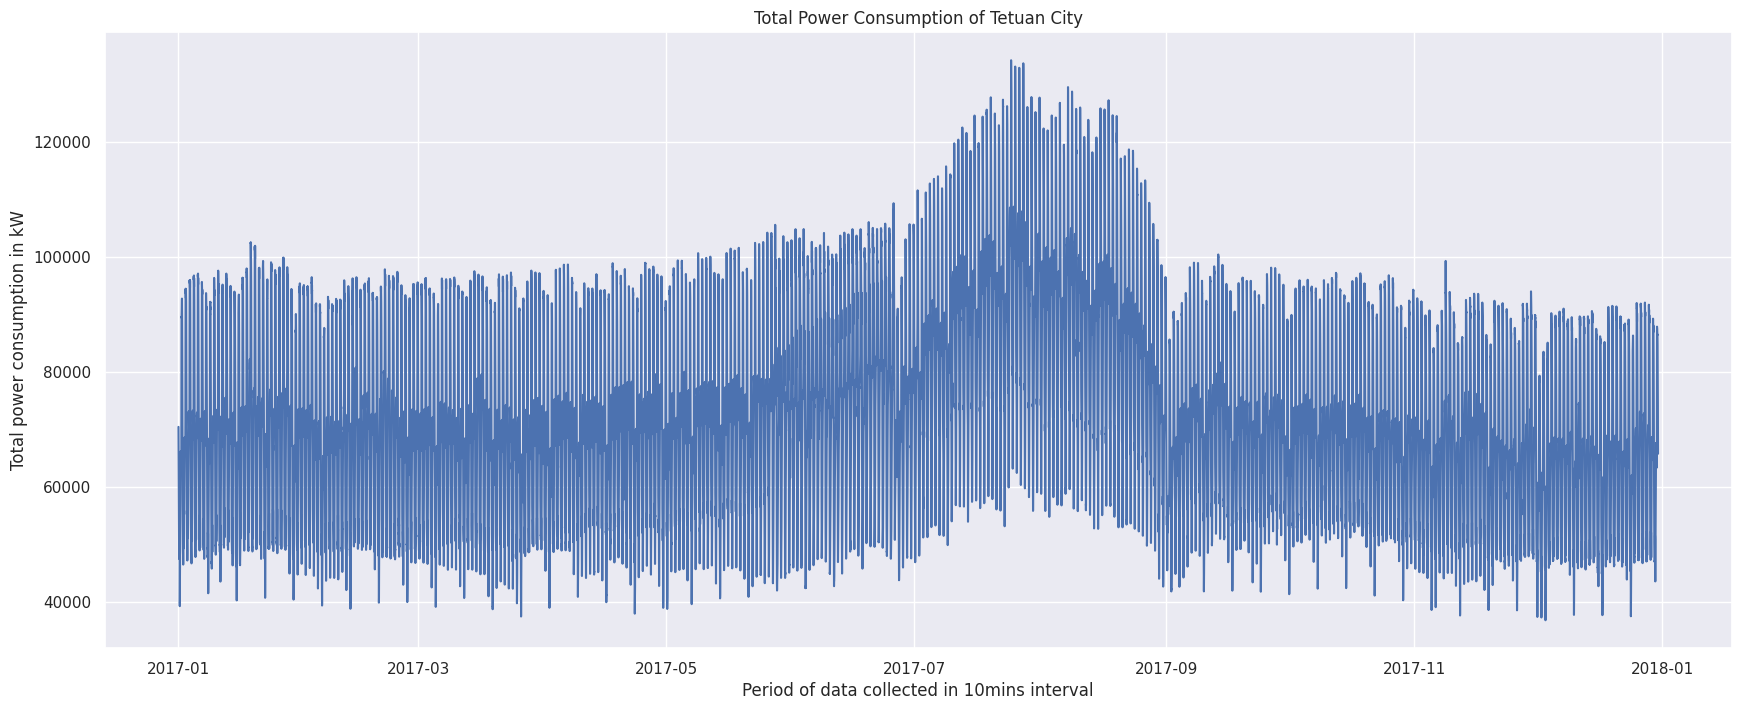

In [ ]:
# visualisation of total power consumed throughout the entire period of data collected
plt.figure(figsize=(21, 8))
plt.plot(visualise_data['2017-01-01 00:00:00':'2017-12-30 23:50:00'])
plt.title('Total Power Consumption of Tetuan City')
plt.ylabel('Total power consumption in kW')
plt.xlabel('Period of data collected in 10mins interval')
plt.show()

In [ ]:
def create_features(df):
    df['Day'] = df['DateTime'].dt.day
    df['Month'] = df['DateTime'].dt.month
    df['Hour'] = df['DateTime'].dt.hour
    df['Minute'] = df['DateTime'].dt.minute
    df['Quarter'] = df['DateTime'].dt.quarter
    df['Year'] = df['DateTime'].dt.year

    # df['weekofyear'] = df['DateTime'].dt.isocalendar().week
    return df

data = create_features(data)
data

DateTime  Temperature  Humidity  Wind Speed  \
0     2017-01-01 00:00:00        6.559      73.8       0.083   
1     2017-01-01 00:10:00        6.414      74.5       0.083   
2     2017-01-01 00:20:00        6.313      74.5       0.080   
3     2017-01-01 00:30:00        6.121      75.0       0.083   
4     2017-01-01 00:40:00        5.921      75.7       0.081   
...                   ...          ...       ...         ...   
52411 2017-12-30 23:10:00        7.010      72.4       0.080   
52412 2017-12-30 23:20:00        6.947      72.6       0.082   
52413 2017-12-30 23:30:00        6.900      72.8       0.086   
52414 2017-12-30 23:40:00        6.758      73.0       0.080   
52415 2017-12-30 23:50:00        6.580      74.1       0.081   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                      0.051          0.119               34055.69620   
1                      0.070          0.085               29814.68354   
2                      0.062          0.100               29128.10127   
3                      0.091          0.096               28228.86076   
4                      0.048          0.085               27335.69620   
...                      ...            ...                       ...   
52411                  0.040          0.096               31160.45627   
52412                  0.051          0.093               30430.41825   
52413                  0.084          0.074               29590.87452   
52414                  0.066          0.089               28958.17490   
52415                  0.062          0.111               28349.80989   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
0                    16128.87538                20240.96386   
1                    19375.07599                20131.08434   
2                    19006.68693                19668.43373   
3                    18361.09422                18899.27711   
4                    17872.34043                18442.40964   
...                          ...                        ...   
52411                26857.31820                14780.31212   
52412                26124.57809                14428.81152   
52413                25277.69254                13806.48259   
52414                24692.23688                13512.60504   
52415                24055.23167                13345.49820   

       Total Power Consumption  Day  Month  Hour  Minute  Quarter  Year  
0                  70425.53544    1      1     0       0        1  2017  
1                  69320.84387    1      1     0      10        1  2017  
2                  67803.22193    1      1     0      20        1  2017  
3                  65489.23209    1      1     0      30        1  2017  
4                  63650.44627    1      1     0      40        1  2017  
...                        ...  ...    ...   ...     ...      ...   ...  
52411              72798.08659   30     12    23      10        4  2017  
52412              70983.80786   30     12    23      20        4  2017  
52413              68675.04965   30     12    23      30        4  2017  
52414              67163.01682   30     12    23      40        4  2017  
52415              65750.53976   30     12    23      50        4  2017  

[52416 rows x 16 columns]

In [ ]:
# keep datetime feature to select the days later on, the features below can be dropped as they are not needed anymore
cleaned_data = data.drop(['Temperature',	'Humidity',	'Wind Speed',	'general diffuse flows', 'diffuse flows',
                  "Zone 1 Power Consumption", "Zone 2  Power Consumption", "Zone 3  Power Consumption"], axis = 1)


In [ ]:
cleaned_data

DateTime  Total Power Consumption  Day  Month  Hour  Minute  \
0     2017-01-01 00:00:00              70425.53544    1      1     0       0   
1     2017-01-01 00:10:00              69320.84387    1      1     0      10   
2     2017-01-01 00:20:00              67803.22193    1      1     0      20   
3     2017-01-01 00:30:00              65489.23209    1      1     0      30   
4     2017-01-01 00:40:00              63650.44627    1      1     0      40   
...                   ...                      ...  ...    ...   ...     ...   
52411 2017-12-30 23:10:00              72798.08659   30     12    23      10   
52412 2017-12-30 23:20:00              70983.80786   30     12    23      20   
52413 2017-12-30 23:30:00              68675.04965   30     12    23      30   
52414 2017-12-30 23:40:00              67163.01682   30     12    23      40   
52415 2017-12-30 23:50:00              65750.53976   30     12    23      50   

       Quarter  Year  
0            1  2017  
1            1  2017  
2            1  2017  
3            1  2017  
4            1  2017  
...        ...   ...  
52411        4  2017  
52412        4  2017  
52413        4  2017  
52414        4  2017  
52415        4  2017  

[52416 rows x 8 columns]

In [ ]:
# selecting the last 15 days for model comparison
start_date = '2017-12-16 00:00:00'
end_date = '2017-12-30 23:50:00'
mask = (cleaned_data['DateTime'] >= start_date) & (cleaned_data['DateTime'] <= end_date)
last_15_days = cleaned_data.loc[mask]
last_15_days

DateTime  Total Power Consumption  Day  Month  Hour  Minute  \
50256 2017-12-16 00:00:00              61346.07666   16     12     0       0   
50257 2017-12-16 00:10:00              59841.73153   16     12     0      10   
50258 2017-12-16 00:20:00              58469.28636   16     12     0      20   
50259 2017-12-16 00:30:00              57239.78104   16     12     0      30   
50260 2017-12-16 00:40:00              56161.60690   16     12     0      40   
...                   ...                      ...  ...    ...   ...     ...   
52411 2017-12-30 23:10:00              72798.08659   30     12    23      10   
52412 2017-12-30 23:20:00              70983.80786   30     12    23      20   
52413 2017-12-30 23:30:00              68675.04965   30     12    23      30   
52414 2017-12-30 23:40:00              67163.01682   30     12    23      40   
52415 2017-12-30 23:50:00              65750.53976   30     12    23      50   

       Quarter  Year  
50256        4  2017  
50257        4  2017  
50258        4  2017  
50259        4  2017  
50260        4  2017  
...        ...   ...  
52411        4  2017  
52412        4  2017  
52413        4  2017  
52414        4  2017  
52415        4  2017  

[2160 rows x 8 columns]

In [ ]:
data_train, data_test =np.split(last_15_days, [int(0.7 *len(last_15_days))])
X_train = data_train[['Day', 'Month', 'Hour', 'Minute', 'Quarter']]
y_train = data_train[['Total Power Consumption']]
X_test = data_test[['Day', 'Month', 'Hour', 'Minute', 'Quarter']]
y_test = data_test[['Total Power Consumption']]

In [ ]:
rfr = RandomForestRegressor(random_state = 42)
rfr.fit(X_train, y_train)

<ipython-input-85-0a58dafa7043>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rfr.predict(X_test)
rfr_df = pd.DataFrame({'Actual': y_test['Total Power Consumption'], 'Prediction': y_pred})
rfr_df.reset_index(drop = True)

Actual    Prediction
0    68619.355085  68957.262673
1    69654.302581  68950.578536
2    70247.423480  69104.074161
3    70852.390870  69296.004102
4    70748.015480  69471.435719
..            ...           ...
643  72798.086590  69742.795746
644  70983.807860  68183.724905
645  68675.049650  66342.903367
646  67163.016820  64539.575707
647  65750.539760  63270.504486

[648 rows x 2 columns]

In [ ]:
data_test['Prediction'] = y_pred
visualise_data = pd.concat([data_train, data_test], sort = False)

In [ ]:
visualise_data

DateTime  Total Power Consumption  Day  Month  Hour  Minute  \
50256 2017-12-16 00:00:00              61346.07666   16     12     0       0   
50257 2017-12-16 00:10:00              59841.73153   16     12     0      10   
50258 2017-12-16 00:20:00              58469.28636   16     12     0      20   
50259 2017-12-16 00:30:00              57239.78104   16     12     0      30   
50260 2017-12-16 00:40:00              56161.60690   16     12     0      40   
...                   ...                      ...  ...    ...   ...     ...   
52411 2017-12-30 23:10:00              72798.08659   30     12    23      10   
52412 2017-12-30 23:20:00              70983.80786   30     12    23      20   
52413 2017-12-30 23:30:00              68675.04965   30     12    23      30   
52414 2017-12-30 23:40:00              67163.01682   30     12    23      40   
52415 2017-12-30 23:50:00              65750.53976   30     12    23      50   

       Quarter  Year    Prediction  
50256        4  2017           NaN  
50257        4  2017           NaN  
50258        4  2017           NaN  
50259        4  2017           NaN  
50260        4  2017           NaN  
...        ...   ...           ...  
52411        4  2017  69742.795746  
52412        4  2017  68183.724905  
52413        4  2017  66342.903367  
52414        4  2017  64539.575707  
52415        4  2017  63270.504486  

[2160 rows x 9 columns]

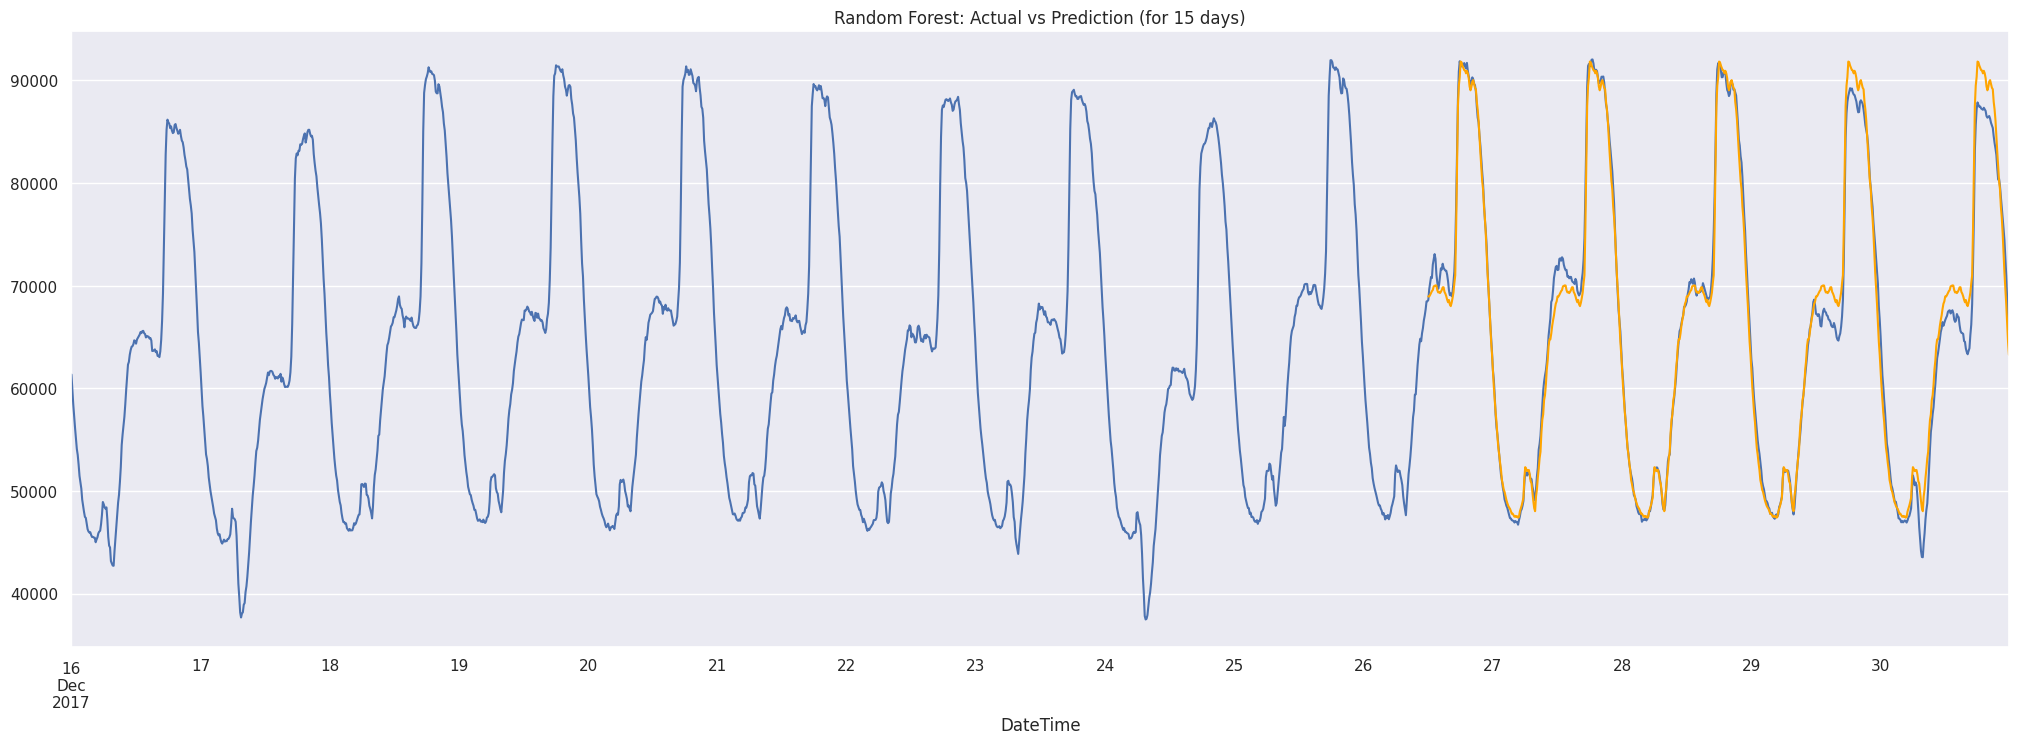

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8))
visualise_data.plot(x='DateTime', y='Total Power Consumption', ax=ax)
visualise_data.plot(x='DateTime', y='Prediction', ax=ax, color = 'orange')

# ax.set_xlabel('DateTime')
# ax.set_ylabel('Total Power Consumption')
ax.set_title('Random Forest: Actual vs Prediction (for 15 days)')

plt.legend('',frameon=False)
plt.show()

In [ ]:
print('\nAccuracy Assessment for using Random Forest Regressor \n')
# print('Explained Variance:\t{:.4f}'.format(explained_variance_score(y_test, y_pred)))
# print('MSE value:\t\t{:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('RSME value:\t\t{:.2f}'.format(mean_squared_error(y_test, y_pred, squared = False)))
print('MAPE value:\t\t{:.8f}'.format((mean_absolute_percentage_error(y_test, y_pred))))


Accuracy Assessment for using Random Forest Regressor 

RSME value:		1827.26
MAPE value:		0.02013709


# Second Portion: Using the entire dataset to train the model

In [ ]:
cleaned_data

DateTime  Total Power Consumption  Day  Month  Hour  Minute  \
0     2017-01-01 00:00:00              70425.53544    1      1     0       0   
1     2017-01-01 00:10:00              69320.84387    1      1     0      10   
2     2017-01-01 00:20:00              67803.22193    1      1     0      20   
3     2017-01-01 00:30:00              65489.23209    1      1     0      30   
4     2017-01-01 00:40:00              63650.44627    1      1     0      40   
...                   ...                      ...  ...    ...   ...     ...   
52411 2017-12-30 23:10:00              72798.08659   30     12    23      10   
52412 2017-12-30 23:20:00              70983.80786   30     12    23      20   
52413 2017-12-30 23:30:00              68675.04965   30     12    23      30   
52414 2017-12-30 23:40:00              67163.01682   30     12    23      40   
52415 2017-12-30 23:50:00              65750.53976   30     12    23      50   

       Quarter  Year  
0            1  2017  
1            1  2017  
2            1  2017  
3            1  2017  
4            1  2017  
...        ...   ...  
52411        4  2017  
52412        4  2017  
52413        4  2017  
52414        4  2017  
52415        4  2017  

[52416 rows x 8 columns]

In [ ]:
data_train, data_test =np.split(cleaned_data, [int(0.7 *len(cleaned_data))])
X_train = data_train[['Day', 'Month', 'Hour', 'Minute', 'Quarter']]
y_train = data_train[['Total Power Consumption']]
X_test = data_test[['Day', 'Month', 'Hour', 'Minute', 'Quarter']]
y_test = data_test[['Total Power Consumption']]

In [ ]:
rfr_whole = RandomForestRegressor(random_state = 42)
rfr_whole.fit(X_train, y_train)
y_pred = rfr_whole.predict(X_test)
rfr_whole_df = pd.DataFrame({'Actual': y_test['Total Power Consumption'], 'Prediction': y_pred})
rfr_whole_df.reset_index(drop = True)

<ipython-input-93-d8491e50feb8>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_whole.fit(X_train, y_train)


Actual    Prediction
0      97658.59438  96520.443277
1      98351.81809  96624.093056
2      98147.12070  96573.037964
3      97887.05132  96421.252322
4      97697.54455  96212.531252
...            ...           ...
15720  72798.08659  74976.253793
15721  70983.80786  73027.190233
15722  68675.04965  71137.980794
15723  67163.01682  69916.758787
15724  65750.53976  68507.766723

[15725 rows x 2 columns]

In [ ]:
data_test['Prediction'] = y_pred
visualise_wholedata = pd.concat([data_train, data_test], sort = False)
visualise_wholedata

DateTime  Total Power Consumption  Day  Month  Hour  Minute  \
0     2017-01-01 00:00:00              70425.53544    1      1     0       0   
1     2017-01-01 00:10:00              69320.84387    1      1     0      10   
2     2017-01-01 00:20:00              67803.22193    1      1     0      20   
3     2017-01-01 00:30:00              65489.23209    1      1     0      30   
4     2017-01-01 00:40:00              63650.44627    1      1     0      40   
...                   ...                      ...  ...    ...   ...     ...   
52411 2017-12-30 23:10:00              72798.08659   30     12    23      10   
52412 2017-12-30 23:20:00              70983.80786   30     12    23      20   
52413 2017-12-30 23:30:00              68675.04965   30     12    23      30   
52414 2017-12-30 23:40:00              67163.01682   30     12    23      40   
52415 2017-12-30 23:50:00              65750.53976   30     12    23      50   

       Quarter  Year    Prediction  
0            1  2017           NaN  
1            1  2017           NaN  
2            1  2017           NaN  
3            1  2017           NaN  
4            1  2017           NaN  
...        ...   ...           ...  
52411        4  2017  74976.253793  
52412        4  2017  73027.190233  
52413        4  2017  71137.980794  
52414        4  2017  69916.758787  
52415        4  2017  68507.766723  

[52416 rows x 9 columns]

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8))
visualise_wholedata.plot(x='DateTime', y='Total Power Consumption', ax=ax)
visualise_wholedata.plot(x='DateTime', y='Prediction', ax=ax, color = 'orange')

ax.set_xlabel('DateTime')
ax.set_ylabel('Total Power Consumption')
ax.set_title('Actual vs Prediction (for entire dataset)')

plt.show()

In [ ]:
print('\nAccuracy Assessment for using Random Forest Regressor \n')
print('Explained Variance:\t{:.4f}'.format(explained_variance_score(y_test, y_pred)))
print('MSE value:\t\t{:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('RSME value:\t\t{:.4f}'.format(mean_squared_error(y_test, y_pred, squared = False)))
print('MAPE value:\t\t{:.4f}'.format(mean_absolute_percentage_error(y_test, y_pred)))


Accuracy Assessment for using Random Forest Regressor 

Explained Variance:	0.8049
MSE value:		52401243.7258
RSME value:		7238.8703
MAPE value:		0.0950
